Import all required python modules.

In [1]:
import cf_units
import cftime

In [2]:
import iris
import ncdata
import numpy as np
import xarray as xr

In [3]:
from pathlib import Path

In [4]:
import matplotlib.pyplot as plt
import iris.quickplot as qplt

In [5]:
from ncdata.iris_xarray import cubes_to_xarray, cubes_from_xarray

In [6]:
iris.FUTURE.date_microseconds = True

In [7]:
iris.FUTURE.save_split_attrs = True

Load the grid mask data to use to regrid the ozone data.

In [8]:
esm_grid_mask_filepath = Path('/g/data/vk83/configurations/inputs/access-esm1p5/modern/share/atmosphere/grids/global.N96/2020.05.19/qrparm.mask')

In [9]:
grid_cube = iris.load_cube(esm_grid_mask_filepath)
grid_cube.coord("latitude").guess_bounds()
grid_cube.coord("longitude").guess_bounds()

In [10]:
lat_points = grid_cube.coord("latitude").points
lon_points = grid_cube.coord("longitude").points

In [11]:
grid_coords = [("latitude", lat_points), ("longitude", lon_points)]

Load the ozone forcing data.

In [12]:
cmip7_pi_ozone_filepath = Path('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/FZJ/FZJ-CMIP-ozone-1-2/atmos/monC/vmro3/gn/v20251010/vmro3_input4MIPs_ozone_CMIP_FZJ-CMIP-ozone-1-2_gn_185001-185012-clim.nc')

In [13]:
orig_ozone_cubelist = iris.load(cmip7_pi_ozone_filepath)

In [14]:
name_constraint = iris.Constraint(name="vmro3")

In [15]:
orig_ozone_cube = orig_ozone_cubelist.extract_cube(name_constraint)

In [16]:
orig_ozone_cube

<iris 'Cube' of vmro3 / (moles mole-1) (time: 12; air_pressure: 66; latitude: 96; longitude: 144)>

In [17]:
orig_ozone_cube.coord('time').units

Unit('days since 1850-01-01', calendar='365_day')

Change the pressure units from hPa to Pa to match the available pressure data.

In [18]:
orig_ozone_cube.coord('air_pressure').convert_units('Pa')

Select one month of data: December 1850, to match the one month of available pressure data.

In [19]:
nov = cftime.DatetimeNoLeap(1850, 11, 30)

In [20]:
dec = iris.Constraint(time=lambda cell: cell.point > nov)

In [21]:
dec_ozone_cube = orig_ozone_cube.extract(dec)

In [22]:
dec_ozone_cube.remove_coord('time')

Interpolate the December ozone cube to the grid coordinates used by ESM1.6.

In [23]:
ozone_cube = dec_ozone_cube.interpolate(grid_coords, iris.analysis.Linear())

Plot the ozone data at each pressure level

In [24]:
ozone_cube_pressures = ozone_cube.coord('air_pressure').points

In [25]:
pressure_constraint = lambda index: iris.Constraint(air_pressure=ozone_cube_pressures[index])

In [26]:
cube_at_index = lambda index: ozone_cube.extract(pressure_constraint(index))

level: 1, air pressure: 100000.0


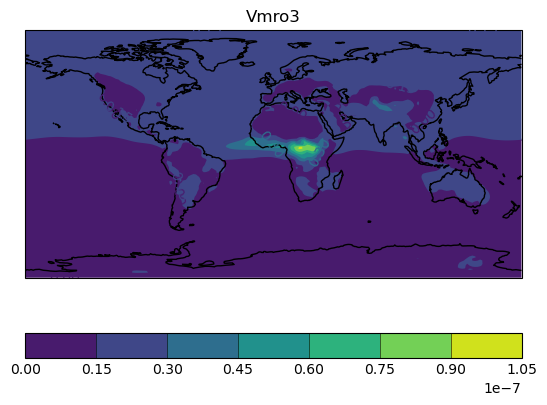

level: 11, air pressure: 45000.0


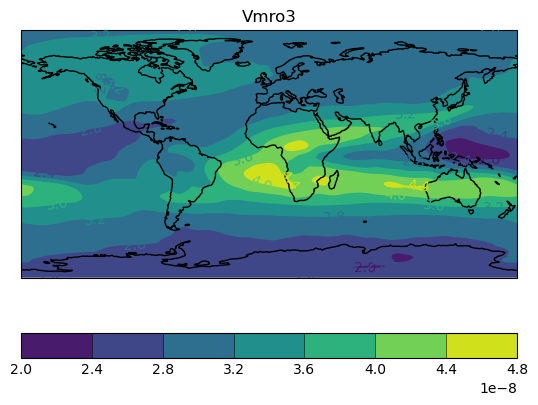

level: 21, air pressure: 11500.0


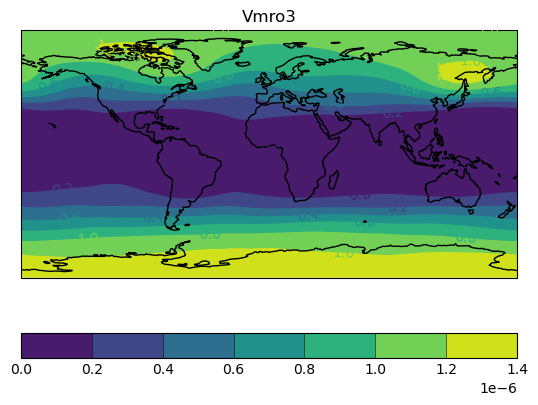

level: 31, air pressure: 2500.0


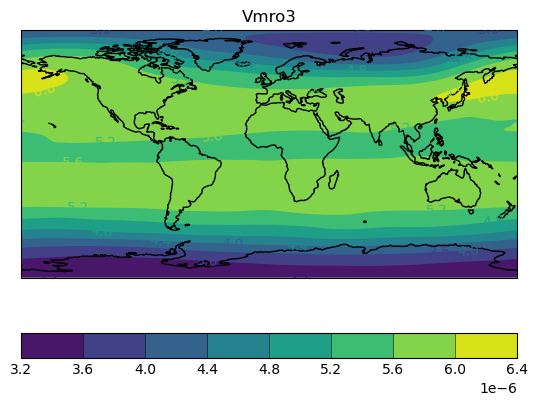

level: 41, air pressure: 100.0


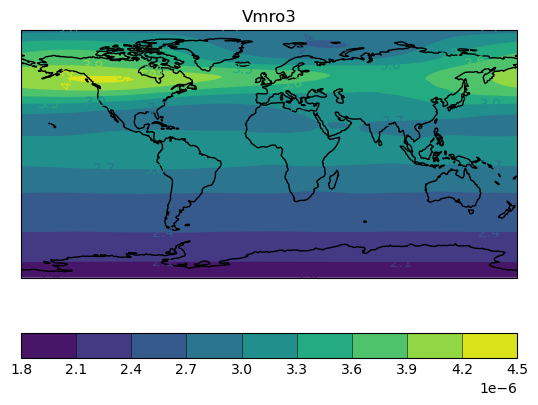

level: 51, air pressure: 4.0


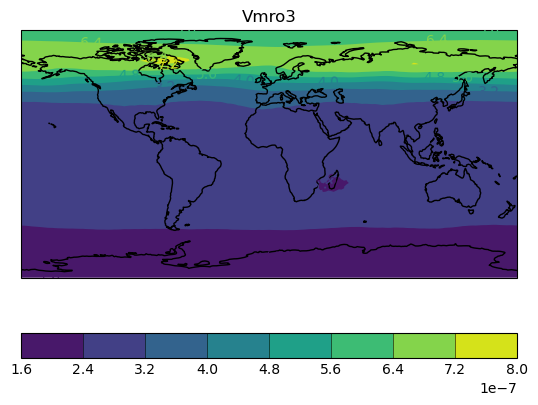

level: 61, air pressure: 0.15


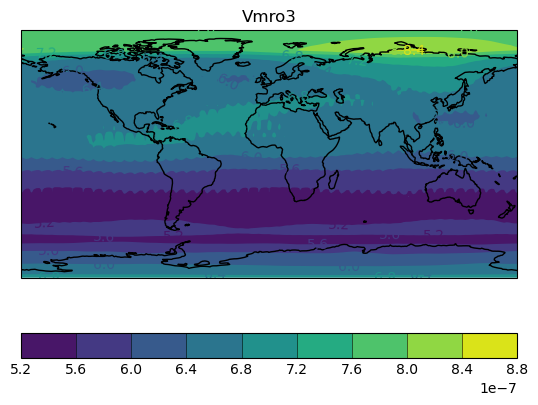

In [27]:
for n in range(0, len(ozone_cube_pressures), 10):
    level = n+1
    pressure = cube_at_index(n).coord('air_pressure').points[0]
    print(f'level: {level}, air pressure: {pressure}')
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube_at_index(n))

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()

In [28]:
filepaths = []
for month in range(1,13):
    spinup_filepath = Path(f'/g/data/p73/archive/CMIP7/ACCESS-ESM1-6/spinup/June2025/output999/atmosphere/netCDF/aiihca.pa-2091{month:02d}_mon.nc')
    filepaths.append(spinup_filepath)

Obtain the pressure data from a spinup file for December 2091.

In [29]:
pressure_ds = xr.open_dataset(filepaths[0])

In [30]:
rho_pressure = pressure_ds['fld_s00i407'].rename('air_pressure')

In [31]:
rho_pressure

<xarray.DataArray 'air_pressure' (time: 1, model_rho_level_number: 38,
                                  lat: 145, lon: 192)> Size: 4MB
[1057920 values with dtype=float32]
Coordinates:
  * time                    (time) datetime64[ns] 8B 2091-01-16T12:00:00
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
  * model_rho_level_number  (model_rho_level_number) int32 152B 1 2 3 ... 37 38
    rho_level_height        (model_rho_level_number) float64 304B ...
    sigma_rho               (model_rho_level_number) float64 304B ...
    surface_altitude        (lat, lon) float64 223kB ...
    height                  float64 8B ...
    height_0                float64 8B ...
    pseudo_level_1          int32 4B ...
Attributes:
    standard_name:    air_pressure
    long_name:        PRESSURE AT RHO LEVELS AFTER TS
    units:            Pa
    um_stash_source:  m01s00i407
    cell_methods:     time: mean
    grid_mapping:     latitude_longitude

In [32]:
rho_height_pressure=rho_pressure.swap_dims({'model_rho_level_number':'rho_level_height'})

In [33]:
import f90nml

In [34]:
parser = f90nml.Parser()
data_nml = parser.read('/g/data/access/umdir/vn7.3/ctldata/vert/vertlevs_G3')

In [35]:
top=data_nml['vertlevs']['z_top_of_model']

In [36]:
eta_rho=np.array(data_nml['vertlevs']['eta_rho'])

In [37]:
eta_rho_heights=eta_rho*top

In [38]:
len(eta_rho_heights)

38

In [39]:
eta_theta=np.array(data_nml['vertlevs']['eta_theta'])

In [40]:
eta_theta_heights=eta_theta*top

In [41]:
len(eta_theta_heights)

39

In [42]:
rho_level_heights=rho_height_pressure['rho_level_height'].data

In [43]:
np.linalg.norm(rho_level_heights-eta_rho_heights)

0.0

In [44]:
target_lat=rho_pressure['lat']
target_lon=rho_pressure['lon']

In [45]:
target_points = {
    'lat': target_lat,
    'lon': target_lon,
    'rho_level_height': eta_theta_heights[1:]
}

Perform the interpolation

In [46]:
log_rho_height_pressure = np.log(rho_height_pressure)

In [47]:
log_height_pressure = log_rho_height_pressure.interp(
    **target_points,
    method='linear',
    kwargs={"fill_value": "extrapolate"}
)

In [48]:
height_pressure = np.exp(log_height_pressure)

In [49]:
renamed_height_pressure=height_pressure.rename({'rho_level_height': 'theta_level_height', 'sigma_rho': 'sigma_theta'})

In [50]:
theta_height_pressure = renamed_height_pressure.assign_attrs(long_name='PRESSURE AT THETA LEVELS AFTER TS', um_stash_source='m01s00i408')

In [51]:
theta_height_pressure

<xarray.DataArray 'air_pressure' (time: 1, theta_level_height: 38, lat: 145,
                                  lon: 192)> Size: 8MB
array([[[[ 69323.56852875,  69323.56852875,  69323.56852875, ...,
           69323.56852875,  69323.56852875,  69323.56852875],
         [ 70203.45468288,  70147.89043311,  70090.9831382 , ...,
           70361.65427092,  70310.79250343,  70258.57716266],
         [ 70978.20659422,  70856.65479754,  70733.03447836, ...,
           71331.10323459,  71215.53468302,  71098.32262325],
         ...,
         [100056.53289712, 100046.87196636, 100037.49817757, ...,
          100086.78599896, 100076.52563808, 100066.38562208],
         [100166.13662649, 100162.50670913, 100159.09184587, ...,
          100177.81533104, 100173.73121182, 100169.83831773],
         [100334.54683797, 100334.54683797, 100334.54683797, ...,
          100334.54683797, 100334.54683797, 100334.54683797]],

        [[ 68938.94966214,  68938.94966214,  68938.94966214, ...,
           68938.94966214,  68938.94966214,  68938.94966214],
         [ 69809.65979587,  69754.73152669,  69698.54199804, ...,
           69965.89604692,  69915.64540809,  69864.09829544],
         [ 70575.42159756,  70455.31548214,  70333.17510129, ...,
           70924.1088919 ,  70809.93412299,  70694.09752961],
...
         [   387.17251087,    386.66453621,    386.17668987, ...,
             388.81253611,    388.24688022,    387.70000096],
         [   394.90395944,    394.64034039,    394.38705788, ...,
             395.7543251 ,    395.46118898,    395.17760851],
         [   403.93777641,    403.93777641,    403.93777641, ...,
             403.93777641,    403.93777641,    403.93777641]],

        [[   357.72647847,    357.72647847,    357.72647847, ...,
             357.72647847,    357.72647847,    357.72647847],
         [   357.59930312,    357.60076505,    357.60222699, ...,
             357.59538377,    357.59661248,    357.59801171],
         [   357.37366797,    357.37680552,    357.38000574, ...,
             357.36534059,    357.36807459,    357.37070087],
         ...,
         [   118.54605195,    118.28175994,    118.02820454, ...,
             119.4007241 ,    119.1057812 ,    118.82079512],
         [   122.71386324,    122.5771574 ,    122.44597361, ...,
             123.15556073,    123.00320109,    122.85585943],
         [   127.5310637 ,    127.5310637 ,    127.5310637 , ...,
             127.5310637 ,    127.5310637 ,    127.5310637 ]]]])
Coordinates:
  * time                    (time) datetime64[ns] 8B 2091-01-16T12:00:00
    model_rho_level_number  (theta_level_height) float64 304B 1.25 ... 38.63
    sigma_theta             (theta_level_height) float64 304B 0.9977 ... 0.0
    surface_altitude        (lat, lon) float64 223kB 2.802e+03 2.802e+03 ... 0.0
    height                  float64 8B ...
    height_0                float64 8B ...
    pseudo_level_1          int32 4B ...
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
  * theta_level_height      (theta_level_height) float64 304B 20.0 ... 3.925e+04
Attributes:
    standard_name:    air_pressure
    long_name:        PRESSURE AT THETA LEVELS AFTER TS
    units:            Pa
    um_stash_source:  m01s00i408
    cell_methods:     time: mean
    grid_mapping:     latitude_longitude

In [52]:
stats = lambda x: [float(x.min().data), float(x.mean().data), float(x.max().data)]

In [53]:
print([f'{s:1f}' for s in stats(rho_height_pressure)])

['182.986481', '43661.617188', '104726.812500']


In [54]:
print([f'{s:.1f}' for s in stats(theta_height_pressure)])

['96.4', '42372.8', '104594.6']


In [55]:
pressure_da = theta_height_pressure

Identify the ozone concentration variable

In [56]:
ozone_var = 'vmro3'

Convert the ozone cube to an XArray DataSet

In [57]:
ozone_ds = cubes_to_xarray(ozone_cube)

Rename the air pressure coordinate to 'air_pressure'

In [58]:
ozone_ds = ozone_ds.rename({'plev': 'air_pressure'})

Extrapolate the ozone air_pressure coordinate from 1.0e5 to 1.09e5 to allow for the full range of possible surface air pressures.

In [59]:
ozone_air_pressure = ozone_ds['air_pressure'].data

In [60]:
ozone_air_pressure_newmax = (ozone_air_pressure.max() * 1.09)

In [61]:
ozone_air_pressure_ext = np.insert(ozone_air_pressure, 0, ozone_air_pressure_newmax)

In [62]:
log_ozone_ds = np.log(ozone_ds)

In [63]:
log_ozone_ds_ext = log_ozone_ds.interp(air_pressure=ozone_air_pressure_ext, kwargs={"fill_value": "extrapolate"})

The target 'lat' and 'lon' values are the existing coordinates in pressure_ds.

In [64]:
target_lat = pressure_da['lat']
target_lon = pressure_da['lon']

The target 'air_pressure' values are the 'fld_s00i407' Data Variable in pressure_ds, temporarily renamed to 'air_pressure'

Use the kwargs syntax for unstructured interpolation

In [65]:
target_points = {
    'lat': target_lat,
    'lon': target_lon,
    'air_pressure': pressure_da
}

Perform the interpolation

In [66]:
log_ozone_at_level = log_ozone_ds_ext[ozone_var].interp(
    **target_points,
    method='linear'
)

In [67]:
ozone_at_level = np.exp(log_ozone_at_level)

In [68]:
ozone_at_level

<xarray.DataArray 'vmro3' (time: 1, theta_level_height: 38, lat: 145, lon: 192)> Size: 4MB
dask.array<exp, shape=(1, 38, 145, 192), dtype=float32, chunksize=(1, 38, 145, 192), chunktype=numpy.MaskedArray>
Coordinates:
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
    air_pressure            (time, theta_level_height, lat, lon) float64 8MB ...
    height                  float64 8B 10.0
    height_0                float64 8B 1.5
    pseudo_level_1          int32 4B 1
  * time                    (time) datetime64[ns] 8B 2091-01-16T12:00:00
    model_rho_level_number  (theta_level_height) float64 304B 1.25 ... 38.63
    sigma_theta             (theta_level_height) float64 304B 0.9977 ... 0.0
    surface_altitude        (lat, lon) float64 223kB 2.802e+03 2.802e+03 ... 0.0
  * theta_level_height      (theta_level_height) float64 304B 20.0 ... 3.925e+04
Attributes:
    long_name:     vmro3
    units:         moles mole-1
    cell_methods:  time: mean

In [69]:
ozone_ds = ozone_at_level[0].to_dataset().reset_coords(("height","height_0","pseudo_level_1"),drop=True)

In [70]:
ozone_ds

<xarray.Dataset> Size: 13MB
Dimensions:                 (lat: 145, lon: 192, theta_level_height: 38)
Coordinates:
  * lat                     (lat) float64 1kB -90.0 -88.75 -87.5 ... 88.75 90.0
  * lon                     (lon) float64 2kB 0.0 1.875 3.75 ... 356.2 358.1
    air_pressure            (theta_level_height, lat, lon) float64 8MB 6.932e...
    time                    datetime64[ns] 8B 2091-01-16T12:00:00
    model_rho_level_number  (theta_level_height) float64 304B 1.25 ... 38.63
    sigma_theta             (theta_level_height) float64 304B 0.9977 ... 0.0
    surface_altitude        (lat, lon) float64 223kB 2.802e+03 2.802e+03 ... 0.0
  * theta_level_height      (theta_level_height) float64 304B 20.0 ... 3.925e+04
Data variables:
    vmro3                   (theta_level_height, lat, lon) float32 4MB dask.array<chunksize=(38, 145, 192), meta=numpy.ma.core.MaskedArray>

In [71]:
model_level_number = np.array(range(1,39))

In [72]:
ozone_theta_ds = ozone_ds.assign_coords(model_level_number=('theta_level_height', model_level_number))

In [73]:
ozone_level_ds = ozone_theta_ds.swap_dims({'theta_level_height':'model_level_number'})

In [74]:
ozone_dropped_ds = ozone_level_ds.reset_coords(("model_rho_level_number"),drop=True)

In [75]:
import cf_xarray

In [76]:
ozone_cf_ds=ozone_dropped_ds.cf.add_bounds(keys=('lat','lon','theta_level_height'))

In [77]:
ozone_at_level_cubelist = cubes_from_xarray(ozone_cf_ds)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:381: IrisCfMissingVarWarning: Missing CF-netCDF boundary variable 'time_bnds', referenced by netCDF variable 'time'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:381: IrisCfMissingVarWarning: Missing CF-netCDF boundary variable 'sigma_rho_bnds', referenced by netCDF variable 'sigma_theta'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:664: IrisCfMissingVarWarning: Missing CF-netCDF grid mapping variable 'latitude_longitude', referenced by netCDF variable 'air_pressure'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/fileformats/cf.py:597: IrisCfMissingVarWarning: Missing CF-netCDF formula term variable 'rho_level_height', referenced by netCDF variable 'theta_level_hei

In [78]:
ozone_at_level_cubelist

Vmro3 (moles mole-1),model_level_number,latitude,longitude
Shape,38,145,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
atmosphere_hybrid_height_coordinate,x,-,-
sigma,x,-,-
air_pressure,x,x,x
surface_altitude,-,x,x


In [79]:
[cube.name() for cube in ozone_at_level_cubelist]

['vmro3', 'surface_altitude']

In [80]:
ozone_constraint = iris.Constraint(name=ozone_var)

In [81]:
ozone_ancil_cube = ozone_at_level_cubelist.extract_cube(ozone_constraint)

In [82]:
ozone_ancil_cube.coords()

[<DimCoord: model_level_number / (unknown)  [ 1, 2, ..., 37, 38]  shape(38,)>,
 <DimCoord: latitude / (degrees)  [-90. , -88.75, ..., 88.75, 90. ]+bounds  shape(145,)>,
 <DimCoord: longitude / (degrees)  [ 0. , 1.875, ..., 356.25 , 358.125]+bounds  shape(192,)>,
 <AuxCoord: time / (days since 0001-01-01)  <lazy>>,
 <AuxCoord: atmosphere_hybrid_height_coordinate / (m)  <lazy>+bounds  shape(38,)>,
 <AuxCoord: sigma / (1)  <lazy>  shape(38,)>,
 <AuxCoord: air_pressure / (Pa)  <lazy>  shape(38, 145, 192)>,
 <AuxCoord: surface_altitude / (m)  <lazy>  shape(145, 192)>,
 <AuxCoord: altitude / (m)  <lazy>  shape(145, 192)>]

In [83]:
ozone_ancil_cube

Vmro3 (moles mole-1),model_level_number,latitude,longitude
Shape,38,145,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
atmosphere_hybrid_height_coordinate,x,-,-
sigma,x,-,-
air_pressure,x,x,x
surface_altitude,-,x,x


model_level_number: 1, hybrid_height: 20, minimum ozone: 6.707e-09


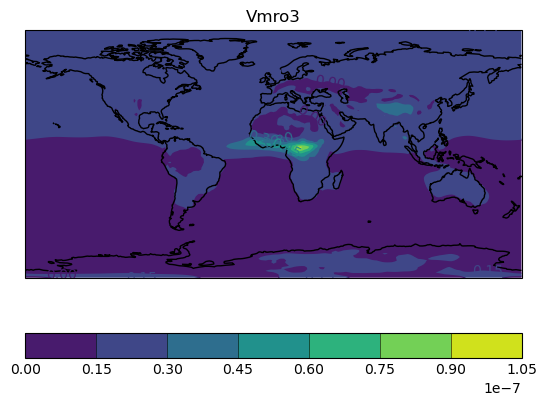

model_level_number: 11, hybrid_height: 2420, minimum ozone: 1.1282e-08


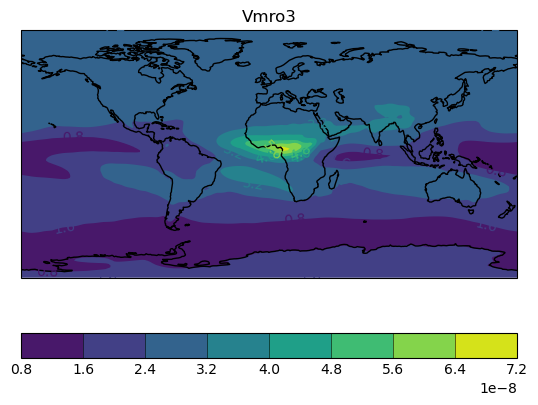

model_level_number: 21, hybrid_height: 8820, minimum ozone: 2.1414e-08


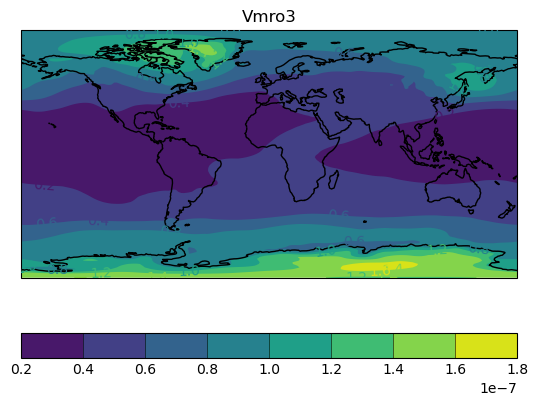

model_level_number: 31, hybrid_height: 19503, minimum ozone: 8.0483e-07


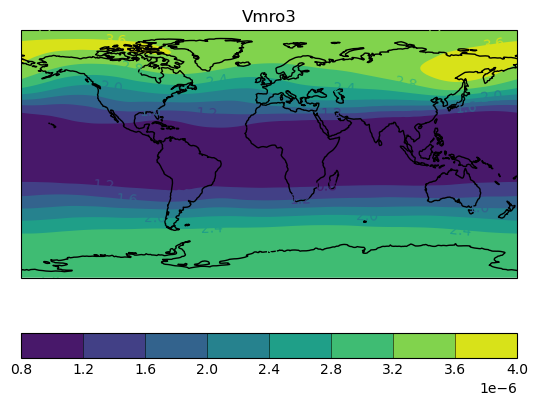

In [84]:
for n in range(39):
  level = n+1
  if level % 10 == 1:
    cube = ozone_ancil_cube[n]
    height = cube.coord('atmosphere_hybrid_height_coordinate').points[0]
    model_level_number = cube.coord('model_level_number').points[0]
    print(f'model_level_number: {model_level_number}, hybrid_height: {height:.5g}', end='')
    cube_da = xr.DataArray.from_iris(cube)
    min_ozone = float(cube_da.min())
    print(f', minimum ozone: {min_ozone:.5g}')
    # Add a filled contour, and put the result in a variable called contour.
    contour = qplt.contourf(cube)

    # Add coastlines to the map created by contour.
    plt.gca().coastlines()
    
    # Add contour labels based on the contour we have just created.
    plt.clabel(contour, inline=False)

    plt.show()

The air pressure extrapolation prevents missing data at the lowest hybrid height levels

In [85]:
ozone_ancil_cube

Vmro3 (moles mole-1),model_level_number,latitude,longitude
Shape,38,145,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
atmosphere_hybrid_height_coordinate,x,-,-
sigma,x,-,-
air_pressure,x,x,x
surface_altitude,-,x,x


In [86]:
cube = ozone_ancil_cube.collapsed('longitude', iris.analysis.MEAN)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/coords.py:2161: IrisVagueMetadataWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'air_pressure'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/coords.py:2161: IrisVagueMetadataWarning: Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'surface_altitude'.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/cube.py:1902: IrisIgnoringBoundsWarning: Orography coordinate 'surface_altitude' has bounds. These will be disregarded.
  factory.update(old_coord, new_coord)


In [87]:
from cf_units import Unit

In [88]:
cube

Vmro3 (moles mole-1),model_level_number,latitude
Shape,38,145
Dimension coordinates,,
model_level_number,x,-
latitude,-,x
Auxiliary coordinates,,
atmosphere_hybrid_height_coordinate,x,-
sigma,x,-
air_pressure,x,x
surface_altitude,-,x
Derived coordinates,,


In [89]:
cube.units

Unit('moles mole-1')

In [90]:
OZONE_MOLAR_MASS = 48.0
DRY_AIR_MOLAR_MASS = 28.97

In [91]:
cube_rescaled = cube * OZONE_MOLAR_MASS / DRY_AIR_MOLAR_MASS

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/aux_factory.py:176: IrisIgnoringBoundsWarning: Orography coordinate 'surface_altitude' has bounds. These will be disregarded.
  return type(self)(**new_dependencies)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/aux_factory.py:176: IrisIgnoringBoundsWarning: Orography coordinate 'surface_altitude' has bounds. These will be disregarded.
  return type(self)(**new_dependencies)


In [92]:
cube_rescaled.standard_name = "mass_fraction_of_ozone_in_air"

In [93]:
cube_rescaled.units = cf_units.Unit('kg kg-1')

In [94]:
STASH = iris.fileformats.pp.STASH

In [95]:
cube_rescaled.attributes.locals = {'source': 'Ancillary processed from CMIP7 ozone forcing FZJ-CMIP-ozone-1-2',
 'um_version': '7.3',
 'STASH': STASH(model=1, section=0, item=60)}

In [96]:
cube_rescaled

Mass Fraction Of Ozone In Air (kg kg-1),model_level_number,latitude
Shape,38,145
Dimension coordinates,,
model_level_number,x,-
latitude,-,x
Auxiliary coordinates,,
atmosphere_hybrid_height_coordinate,x,-
sigma,x,-
air_pressure,x,x
surface_altitude,-,x
Derived coordinates,,


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/iris/coords.py:1982: IrisGuessBoundsWarning: Coordinate 'model_level_number' is not bounded, guessing contiguous bounds.
  warnings.warn(


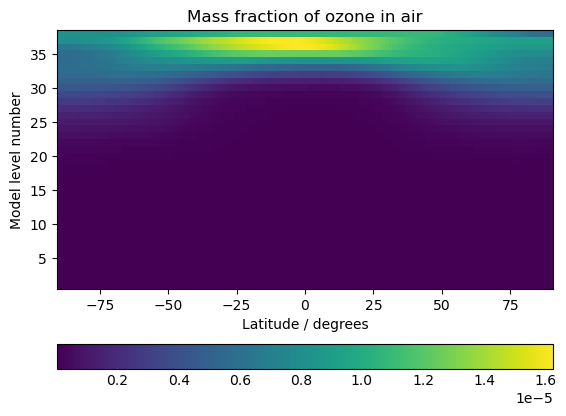

In [97]:
qplt.pcolormesh(cube_rescaled, coords=('latitude','model_level_number'))